In [2]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection

In [3]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']

Nur Info

In [4]:
ok_dir = os.path.join(BASE_DIR, DATA_OK[0])
zugversuch = pd.read_csv(os.path.join(ok_dir, 'zugversuch.csv'), sep=';', decimal=',')
zugversuch.columns = ['nr', 'festigkeit']
zugversuch['nr'] = zugversuch.nr.astype('str')
zugversuch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nr          200 non-null    object
 1   festigkeit  200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [5]:
def read_special_csv(path):
    res = list()
    flag = False
    for line in open(path):
        if line.strip() == '#CSV-START#':
            flag = True
            continue
        if flag:
            res.append(line)
    #print('\n'.join(res)[:20])
    #return '\n'.join(res)
    stream = io.StringIO('\n'.join(res))
    df = pd.read_csv(stream, sep=';')
    df.columns = ['ms', 'power', 'force', 'dist']
    return df
    

In [6]:
def read_kurven(data_dir, df_zug, kurven_dict, prefix):
    max_row_count = 0
    min_row_count = 999999999
    for nr in df_zug.nr:
        df = read_special_csv(os.path.join(data_dir, 'schweisskurven', nr+'.csv'))
        kurven_dict[prefix+nr] = df
        if df.shape[0] > max_row_count:
            max_row_count = df.shape[0]
        if df.shape[0] < min_row_count:
            min_row_count = df.shape[0]
    print(f'count {len(df_zug)} rows {min_row_count}...{max_row_count}')

TODO: DATA_OK, DATA_FEHLER zu DATA zusammenfassen

In [7]:
kurven = dict()
label = dict()
zugversuche = list()
# target labels for fail data
for idx, fname in enumerate(DATA_OK):
    label[fname] = idx
for idx, fname in enumerate(DATA_FEHLER):
    label[fname] = idx+len(DATA_OK)
for data_ok in DATA_OK:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_ok, 'zugversuch.csv'), sep=';', decimal=',')
    zugversuch.columns = ['nr', 'festigkeit']
    prefix = data_ok + '_'
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_ok]
    zugversuch['group'] = data_ok
    read_kurven(os.path.join(BASE_DIR, data_ok), zugversuch, kurven, prefix)
    zugversuche.append(zugversuch)
for data_fehl in DATA_FEHLER:
    zugversuch = pd.read_csv(os.path.join(BASE_DIR, data_fehl, 'zugversuch.csv'), sep=';', decimal=',')
    prefix = data_fehl + '_'
    zugversuch.columns = ['nr', 'festigkeit']
    zugversuch['nr'] = zugversuch.nr.astype('str')
    zugversuch['key'] = prefix + zugversuch.nr
    zugversuch['label'] = label[data_fehl]
    zugversuch['group'] = data_fehl
    read_kurven(os.path.join(BASE_DIR, data_fehl), zugversuch, kurven, prefix)
    zugversuche.append(zugversuch)
zugversuche = pd.concat(zugversuche, ignore_index=True)


count 200 rows 1407...1650
count 100 rows 1582...1759
count 100 rows 1052...1434
count 100 rows 1716...2403
count 100 rows 1702...2092


In [8]:
zugversuche

,nr,festigkeit,key,label,group
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [9]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2)

In [10]:
versuche_train

,nr,festigkeit,key,label,group
185,1754,2890.000000,ok_1754,0,ok
379,2087,0.000000,fehler_oel_2087,2,fehler_oel
509,2419,1987.522217,fehler_terminversatz_2419,4,fehler_terminversatz
128,1697,2780.000000,ok_1697,0,ok
497,2607,2570.657471,fehler_leitungsversatz_2607,3,fehler_leitungsversatz
...,...,...,...,...,...
17,1586,2710.000000,ok_1586,0,ok
296,3025,2586.420410,near_ok_sonowechsel_3025,1,near_ok_sonowechsel
283,3012,2597.028076,near_ok_sonowechsel_3012,1,near_ok_sonowechsel
130,1699,2630.000000,ok_1699,0,ok


In [11]:
def class_curves(versuche, kurven, feature):
    '''
    versuche: DataFrame Versuchsnummer-Klasse
    kurven: dict. Schweißkurven
    feature: feature (power, force, dist)
    '''
    color = ['black', 'blue', 'red', 'green', 'cyan']
    for _, v in versuche.iterrows():
        kurve = kurven[v['key']]
        c = v['label']
        plt.plot(kurve.ms, kurve[feature], c=color[c], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

In [12]:
#versuche_train[:50]

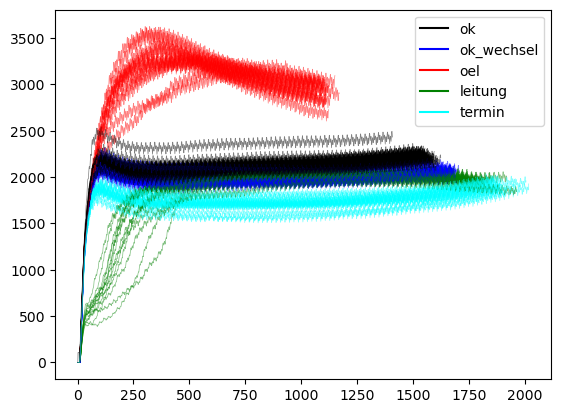

In [13]:
class_curves(versuche_train[:100], kurven, 'power')
plt.savefig('label_power.png')

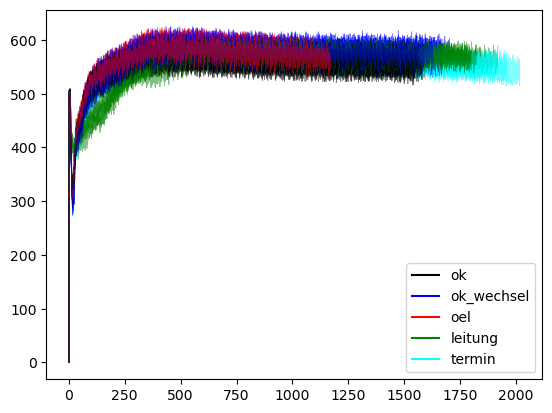

In [14]:
class_curves(versuche_train[:50], kurven, 'force')
plt.savefig('label_force.png')

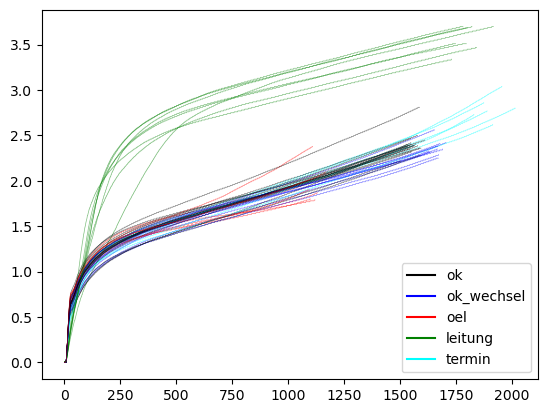

In [15]:
class_curves(versuche_train[:50], kurven, 'dist')
plt.savefig('label_dist.png')

In [16]:
def zug_curves(versuche, kurven, feature):
    fig, ax = plt.subplots()
    marker = ['.', '*', '+', 'o']
    max_fest = versuche['festigkeit'].max()
    print(max_fest)
    cmap = matplotlib.colormaps['rainbow']
    norm = matplotlib.colors.Normalize(0, max_fest)
    for _, v in versuche.iterrows():
        kurve = kurven[v['key']]
        m = v['label']
        color = cmap(v['festigkeit']/max_fest)
        plt.plot(kurve.ms, kurve[feature], c=color, alpha=0.5, linewidth=0.5) #marker[m], c=color)
    handles = [
        matplotlib.lines.Line2D([0], [0], marker='.', label='ok'),
        matplotlib.lines.Line2D([0], [0], marker='*', label='oel'),
        matplotlib.lines.Line2D([0], [0], marker='+', label='leitung'),
        matplotlib.lines.Line2D([0], [0], marker='o', label='termin'),
    ]
    plt.title(f'Zugfestigkeit bzgl. {feature}')
    plt.xlabel('ms')
    plt.ylabel(feature)
    #plt.legend(handles=handles)
    plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm), orientation='vertical', ax=ax, label='Zugfestigkeit')

2990.0


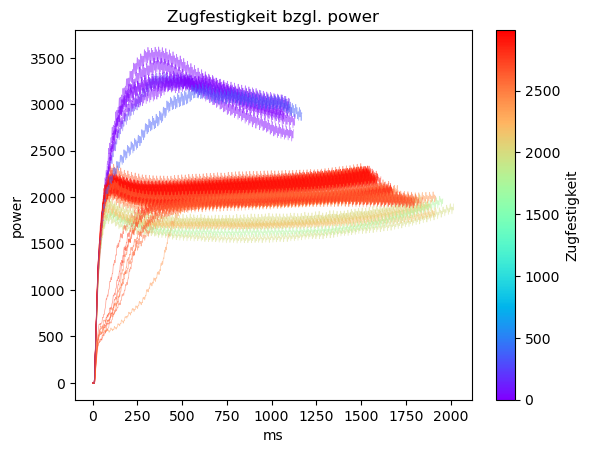

In [17]:
zug_curves(versuche_train[:50], kurven, 'power')
plt.savefig('zug_power.png')

2990.0


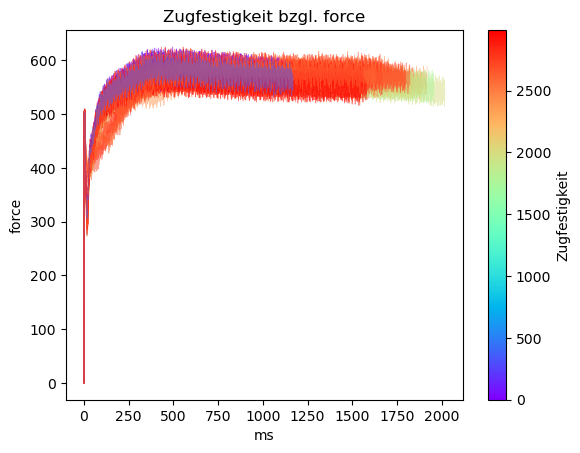

In [18]:
zug_curves(versuche_train[:50], kurven, 'force')
plt.savefig('zug_force.png')

2990.0


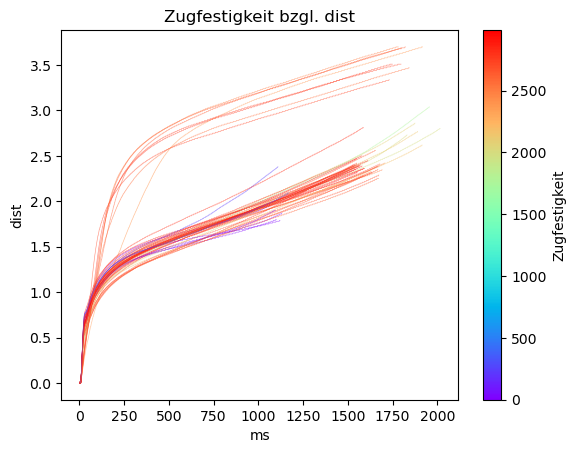

In [19]:
zug_curves(versuche_train[:50], kurven, 'dist')
plt.savefig('zug_dist.png')

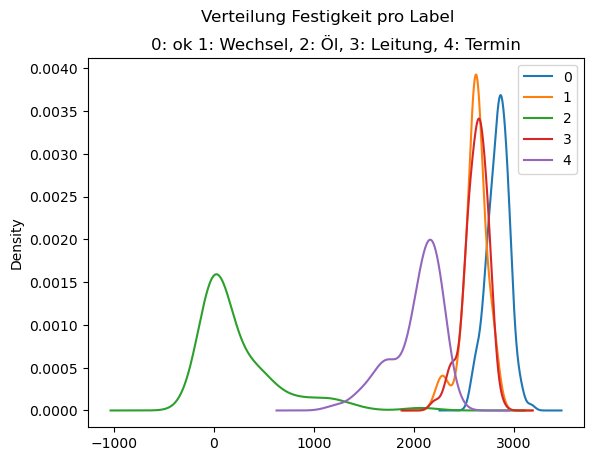

In [20]:
plt.figure()
versuche_train.groupby('label').festigkeit.plot(kind='density', legend=True)
plt.suptitle('Verteilung Festigkeit pro Label')
plt.title('0: ok 1: Wechsel, 2: Öl, 3: Leitung, 4: Termin')
plt.savefig('festigkeit_per_label.png')